<a href="https://colab.research.google.com/github/Deolinda1506/FemInsight-GPT2/blob/main/Notebook/Untitled21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTS(NECESSARY LIBRARIES)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils import resample
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import f1_score
from transformers import pipeline, set_seed, GPT2LMHeadModel, TrainingArguments, Trainer, GPT2Tokenizer # Added GPT2Tokenizer here
import torch
from math import exp
from transformers.trainer_callback import EarlyStoppingCallback

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
from datasets import load_dataset

ds = load_dataset("gjyotk/Menstrual-Health-Awareness-Dataset")

train.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/530 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/45 [00:00<?, ? examples/s]

# Data Exploration


In [3]:
# Display the dataset object
print(ds)

# Display the structure of the training split
print(ds['train'])

# Display the first few examples from the training split
print(ds['train'][:5])

DatasetDict({
    train: Dataset({
        features: ['instruction (string)', 'output (string)'],
        num_rows: 530
    })
    test: Dataset({
        features: ['instruction (string)', 'output (string)'],
        num_rows: 45
    })
})
Dataset({
    features: ['instruction (string)', 'output (string)'],
    num_rows: 530
})
{'instruction (string)': ['What is a normal menstrual cycle length?', 'What are common causes of irregular periods?', 'How can I alleviate menstrual cramps?', 'What are the signs of a heavy menstrual flow?', 'Is it normal to experience mood swings during menstruation?'], 'output (string)': ['A normal menstrual cycle typically ranges from 21 to 35 days, with the average cycle lasting around 28 days.', 'Common causes of irregular periods include hormonal imbalances, stress, excessive exercise, weight changes, thyroid disorders, and certain medical conditions.', 'Menstrual cramps can be alleviated through various methods including over-the-counter pain relievers, 

# Data Visualization


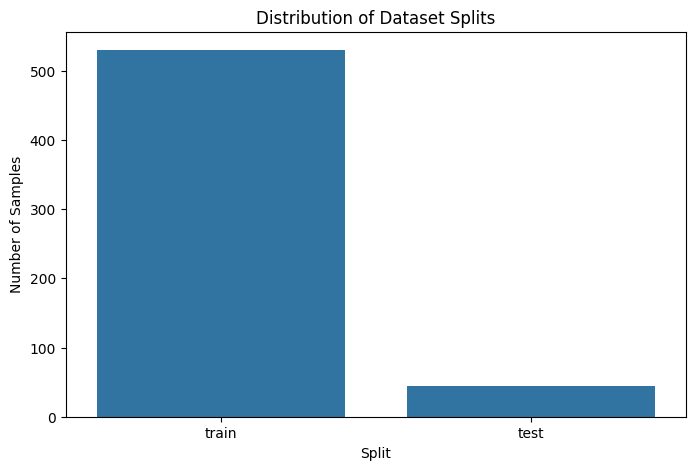

In [4]:
# Dataset Split Distribution
dataset_sizes = {split: len(ds[split]) for split in ds.keys()}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(dataset_sizes.keys()), y=list(dataset_sizes.values()))
plt.title('Distribution of Dataset Splits')
plt.xlabel('Split')
plt.ylabel('Number of Samples')
plt.show()

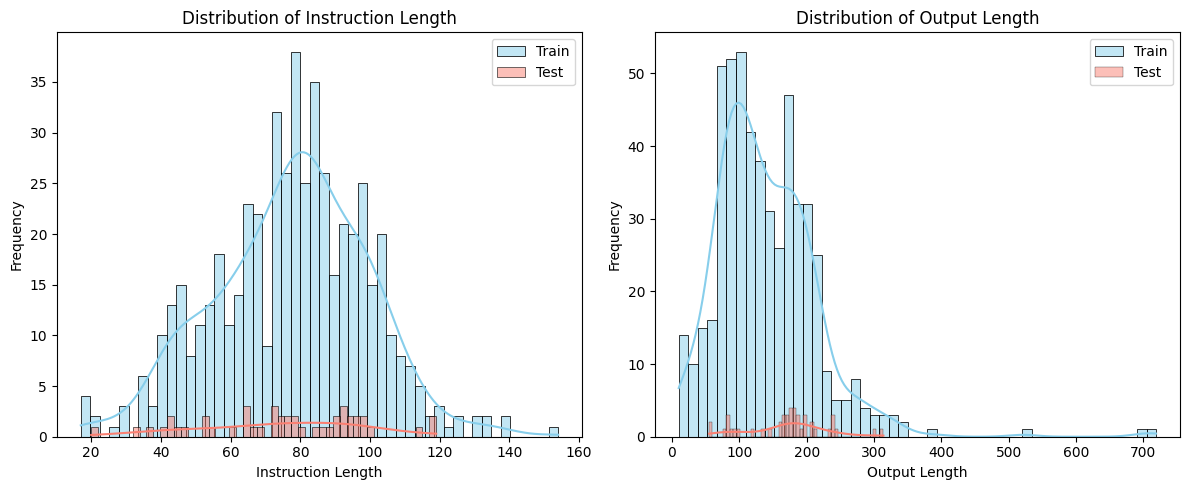

In [5]:
# Convert dataset splits to pandas DataFrames
train_df = ds['train'].to_pandas()
test_df = ds['test'].to_pandas()

train_df['instruction_length'] = train_df['instruction (string)'].apply(len)
train_df['output_length'] = train_df['output (string)'].apply(len)

test_df['instruction_length'] = test_df['instruction (string)'].apply(len)
test_df['output_length'] = test_df['output (string)'].apply(len)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_df['instruction_length'], bins=50, kde=True, color='skyblue', label='Train')
sns.histplot(test_df['instruction_length'], bins=50, kde=True, color='salmon', label='Test')
plt.title('Distribution of Instruction Length')
plt.xlabel('Instruction Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(train_df['output_length'], bins=50, kde=True, color='skyblue', label='Train')
sns.histplot(test_df['output_length'], bins=50, kde=True, color='salmon', label='Test')
plt.title('Distribution of Output Length')
plt.xlabel('Output Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

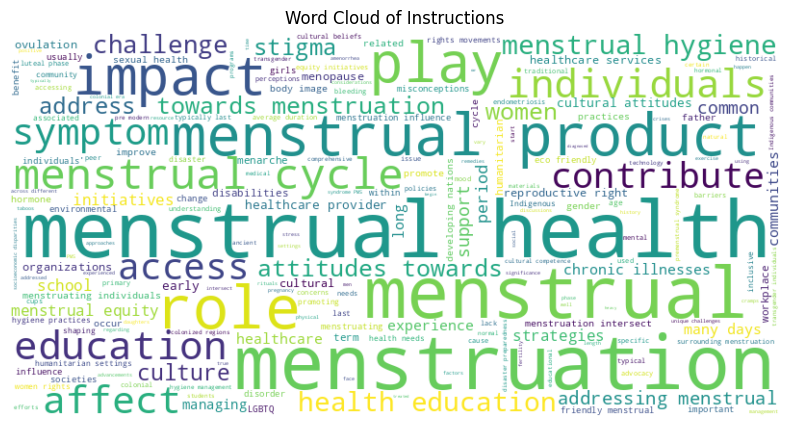

In [6]:

# Generate Word Cloud for Instructions
instruction_text = " ".join(train_df['instruction (string)'].dropna())
wordcloud_instruction = WordCloud(width=800, height=400, background_color='white').generate(instruction_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_instruction, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Instructions')
plt.show()


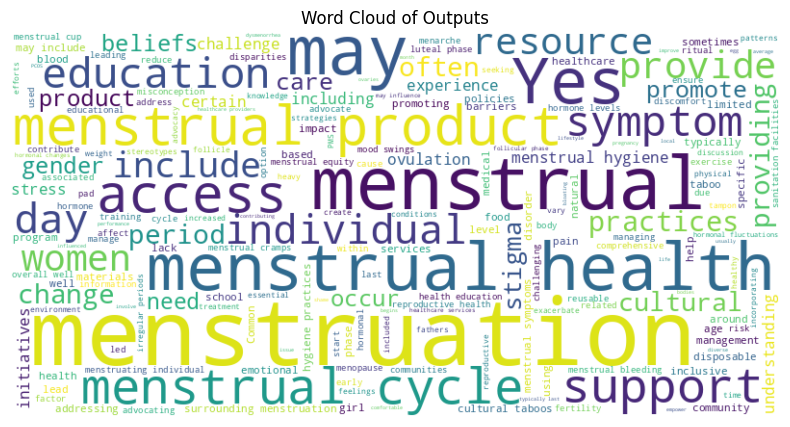

In [7]:
# Generate Word Cloud for Outputs
output_text = " ".join(train_df['output (string)'].dropna())
wordcloud_output = WordCloud(width=800, height=400, background_color='white').generate(output_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_output, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Outputs')
plt.show()

 # Data preprocessing

In [8]:
# Handles missig values though for our dataset there is no missing values
def handle_missing(example):
    # Fill missing instructions with a placeholder
    if pd.isna(example["instruction (string)"]):
        example["instruction (string)"] = "[QUESTION MISSING]"
    # Fill missing outputs with a placeholder
    if pd.isna(example["output (string)"]):
        example["output (string)"] = "[ANSWER MISSING]"
    return example

ds = ds.map(handle_missing)

# Check for missing values after handling
print("Missing values after handling:")
print("train_df:", ds['train'].filter(lambda x: pd.isna(x['instruction (string)']) or pd.isna(x['output (string)'])).num_rows)
print("test_df:", ds['test'].filter(lambda x: pd.isna(x['instruction (string)']) or pd.isna(x['output (string)'])).num_rows)

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Missing values after handling:


Filter:   0%|          | 0/530 [00:00<?, ? examples/s]

train_df: 0


Filter:   0%|          | 0/45 [00:00<?, ? examples/s]

test_df: 0


In [9]:
# Data Preprocessing (Text Cleaning)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


def preprocess_text(example):
    # Get the instruction and output strings
    instruction = example["instruction (string)"]
    output = example["output (string)"]

    # Remove special characters and numbers from instruction
    instruction = re.sub(r'[^a-zA-Z\s]', '', instruction)
    # Convert to lowercase
    instruction = instruction.lower()
    # Tokenization
    instruction_tokens = word_tokenize(instruction)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    instruction_tokens = [word for word in instruction_tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    instruction_tokens = [lemmatizer.lemmatize(word) for word in instruction_tokens]

    # Remove special characters and numbers from output
    output = re.sub(r'[^a-zA-Z\s]', '', output)
    # Convert to lowercase
    output = output.lower()
    # Tokenization
    output_tokens = word_tokenize(output)
    # Remove stop words
    output_tokens = [word for word in output_tokens if word not in stop_words]
    # Lemmatization
    output_tokens = [lemmatizer.lemmatize(word) for word in output_tokens]

    # Join tokens back into strings and add as new columns
    example['preprocessed_instruction'] = ' '.join(instruction_tokens)
    example['preprocessed_output'] = ' '.join(output_tokens)

    return example

# Apply preprocessing to the entire dataset object (both train and test splits)
ds = ds.map(preprocess_text)

print("Text preprocessing complete for both train and test datasets.")
print("\nExample of preprocessed data from train split:")
print(ds['train'][0])
print("\nExample of preprocessed data from test split:")
print(ds['test'][0])

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Text preprocessing complete for both train and test datasets.

Example of preprocessed data from train split:
{'instruction (string)': 'What is a normal menstrual cycle length?', 'output (string)': 'A normal menstrual cycle typically ranges from 21 to 35 days, with the average cycle lasting around 28 days.', 'preprocessed_instruction': 'normal menstrual cycle length', 'preprocessed_output': 'normal menstrual cycle typically range day average cycle lasting around day'}

Example of preprocessed data from test split:
{'instruction (string)': 'What is the physiological process behind menstruation?', 'output (string)': 'Menstruation is the result of complex hormonal interactions orchestrated by the hypothalamus, pituitary gland, ovaries, and uterus, leading to the shedding of the endometrial lining in response to changes in estrogen and progesterone levels.', 'preprocessed_instruction': 'physiological process behind menstruation', 'preprocessed_output': 'menstruation result complex hormonal

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

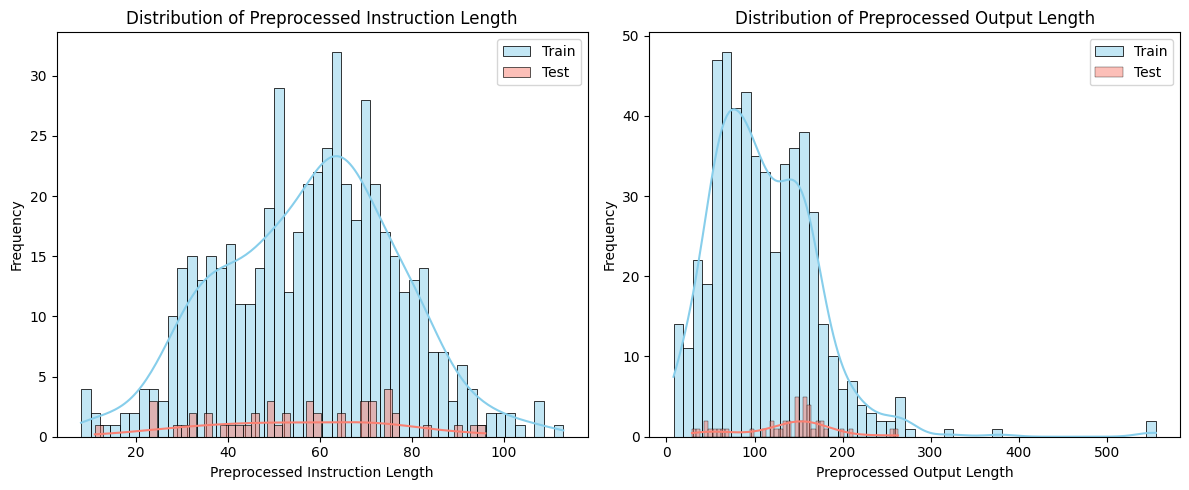

In [10]:
# Calculate length of preprocessed instructions and outputs
ds = ds.map(lambda example: {'preprocessed_instruction_length': len(example['preprocessed_instruction']),
                             'preprocessed_output_length': len(example['preprocessed_output'])})

# Convert to pandas DataFrames for easier plotting
train_preprocessed_df = ds['train'].to_pandas()
test_preprocessed_df = ds['test'].to_pandas()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_preprocessed_df['preprocessed_instruction_length'], bins=50, kde=True, color='skyblue', label='Train')
sns.histplot(test_preprocessed_df['preprocessed_instruction_length'], bins=50, kde=True, color='salmon', label='Test')
plt.title('Distribution of Preprocessed Instruction Length')
plt.xlabel('Preprocessed Instruction Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(train_preprocessed_df['preprocessed_output_length'], bins=50, kde=True, color='skyblue', label='Train')
sns.histplot(test_preprocessed_df['preprocessed_output_length'], bins=50, kde=True, color='salmon', label='Test')
plt.title('Distribution of Preprocessed Output Length')
plt.xlabel('Preprocessed Output Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
def format_for_gpt2(example):
    text = f"Instruction: {example['instruction (string)']}\nOutput: {example['output (string)']}\n\n"
    return {"text": text}

formatted_ds = ds.map(format_for_gpt2)
print(formatted_ds["train"][1]["text"])

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Instruction: What are common causes of irregular periods?
Output: Common causes of irregular periods include hormonal imbalances, stress, excessive exercise, weight changes, thyroid disorders, and certain medical conditions.




# Tokenization

In [12]:

# Initialize tokenizer (force padding for GPU efficiency)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize(examples):
    # Tokenize inputs (with padding/truncation)
    tokenized_inputs = tokenizer(
        examples["text"],
        truncation=True,
        max_length=64,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt"  # Returns PyTorch tensors for GPU
    )

    # Create labels for causal LM (shifted input_ids)
    labels = tokenized_inputs["input_ids"].clone()
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply tokenization (batched for speed)
tokenized_ds = formatted_ds.map(tokenize, batched=True, batch_size=32)

# Inspect sample
sample = tokenized_ds["train"][0]
print("Keys:", sample.keys())  # will show: ['input_ids', 'attention_mask', 'labels']
print("Input IDs:", sample["input_ids"][:5])
print("Labels:", sample["labels"][:5])

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Keys: dict_keys(['instruction (string)', 'output (string)', 'preprocessed_instruction', 'preprocessed_output', 'preprocessed_instruction_length', 'preprocessed_output_length', 'text', 'input_ids', 'attention_mask', 'labels'])
Input IDs: [6310, 2762, 25, 1867, 318]
Labels: [6310, 2762, 25, 1867, 318]


 # Fine-Tuning of GPT-2

 # GPU Acceleration

In [13]:
import torch

# Enable CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Optimizes CUDA ops

# Move data to GPU
tokenized_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
import torch
from transformers import GPT2LMHeadModel, Trainer, TrainingArguments, EarlyStoppingCallback


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# =========================
# Model setup
# =========================
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))  # Adjust vocabulary if pad_token added
print(f"Model is on device: {model.device}") # Check model device

# =========================
# Dataset format
# =========================
# Ensure tokenized_ds contains "input_ids", "attention_mask" and "labels"
# tokenized_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"]) # Removed GPU specific data formatting

# =========================
# Training arguments
# =========================
training_args = TrainingArguments(
    output_dir="./results",
    run_name="gpt2_feminsight_initial",
    weight_decay=0.05,
    per_device_train_batch_size=8, # Changed batch size to 8
    gradient_accumulation_steps=2,
    num_train_epochs=20,  # Reasonable starting point
    eval_strategy="steps",
    eval_steps=100,
    # fp16=True,  # Use mixed precision on GPU - Removed GPU specific argument
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",  # Disable W&B
    # dataloader_num_workers=2, # Removed GPU specific argument
    learning_rate=1e-5,
    warmup_ratio=0.2,
    logging_steps=10,
)

# =========================
# Trainer setup
# =========================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=8)]
)

# =========================
# Start training
# =========================
print("Starting GPT-2 fine-tuning (gpt2_feminsight_initial)...")
trainer.train()
print("Model fine-tuning complete.")


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model is on device: cpu
Starting GPT-2 fine-tuning (gpt2_feminsight_initial)...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
100,1.801200,1.604514


In [ ]:
# Save the fine-tuned model
trainer.save_model("./fine-tuned-gpt2-feminsight")
print("Model saved successfully.")

In [ ]:
# Extract training and evaluation loss from log history
log_history = trainer.state.log_history
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
steps = [entry['step'] for entry in log_history if 'loss' in entry]
eval_steps = [entry['step'] for entry in log_history if 'eval_loss' in entry]


# Plot the loss curves
plt.figure(figsize=(6, 4))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# FemInsight GPT-2 Fine-Tuned Model

from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load your fine-tuned model and tokenizer
model_path = "/content/fine-tuned-gpt2-feminsight"
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Ensure pad token is defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Define a generation function
def feminsight_generate(prompt, max_length=150, temperature=0.8, top_k=50, top_p=0.9):
    """
    Generate a response from the FemInsight GPT-2 model.

    Args:
        prompt (str): Input text prompt.
        max_length (int): Maximum length of generated text.
        temperature (float): Controls randomness (lower = more focused).
        top_k (int): Keeps only top-k likely tokens.
        top_p (float): Nucleus sampling threshold.

    Returns:
        str: Clean, generated text.
    """
    model.eval()

    # Encode the input
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256).to(device)

    # Generate text
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        do_sample=True,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        pad_token_id=tokenizer.eos_token_id,
        num_return_sequences=1
    )

    # Decode and clean the output
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Optional: remove the original prompt for cleaner output
    response = response[len(prompt):].strip()

    return response


#  Example:Educational question

if __name__ == "__main__":
    print(" FemInsight GPT-2 model ready to generate responses \n")

    user_prompt = "What are healthy ways to manage menstrual cramps?"
    response = feminsight_generate(user_prompt)
    print("Prompt:", user_prompt)
    print("FemInsight Response:", response)
    print("\n")


    # Example:Lifestyle advice
    print("Lifestyle Advice")
    prompt2 = "How can I maintain a healthy diet during my period?"
    print("Prompt:", prompt2)
    print("FemInsight Response:", feminsight_generate(prompt2))
    print("\n")


    # Example:Emotional support
    print("Emotional Support")
    prompt3 = "I feel moody and tired before my period. What can I do?"
    print("Prompt:", prompt3)
    print("FemInsight Response:", feminsight_generate(prompt3, max_length=200))
    print("\n")


    # Example:Common myths
    print("Common Myths")
    prompt4 = "Is it true that exercising during menstruation is harmful?"
    print("Prompt:", prompt4)
    print("FemInsight Response:", feminsight_generate(prompt4, top_k=100))
    print("\n")

## Experiments

Let's set up experiments to explore different hyperparameters and their impact on model performance. We will track the results in a table.

In [ ]:
# Define different sets of training arguments for experiments
experiment_args = {
    "experiment_1": TrainingArguments(
        output_dir="./results/experiment_1",
        run_name="gpt2_feminsight_experiment_1",
        weight_decay=0.01, # Lower weight decay
        per_device_train_batch_size=16, # Larger batch size
        gradient_accumulation_steps=1,
        num_train_epochs=10, # Fewer epochs
        eval_strategy="steps",
        eval_steps=100,
        fp16=True if torch.cuda.is_available() else False,
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        dataloader_num_workers=2 if torch.cuda.is_available() else 0,
        learning_rate=5e-5, # Higher learning rate
        warmup_ratio=0.1,
        logging_steps=10,
    ),
    "experiment_2": TrainingArguments(
        output_dir="./results/experiment_2",
        run_name="gpt2_feminsight_experiment_2",
        weight_decay=0.1, # Higher weight decay
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        num_train_epochs=20,
        eval_strategy="steps",
        eval_steps=100,
        fp16=True if torch.cuda.is_available() else False,
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        dataloader_num_workers=2 if torch.cuda.is_available() else 0,
        learning_rate=1e-5,
        warmup_ratio=0.2,
        logging_steps=10,
    ),
    "experiment_3": TrainingArguments(
        output_dir="./results/experiment_3",
        run_name="gpt2_feminsight_experiment_3",
        weight_decay=0.05,
        per_device_train_batch_size=4, # Smaller batch size
        gradient_accumulation_steps=4,
        num_train_epochs=15, # Medium number of epochs
        eval_strategy="steps",
        eval_steps=50, # More frequent evaluation
        fp16=True if torch.cuda.is_available() else False,
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        dataloader_num_workers=2 if torch.cuda.is_available() else 0,
        learning_rate=2e-5, # Slightly higher learning rate
        warmup_ratio=0.15,
        logging_steps=10,
    ),
    "experiment_4": TrainingArguments(
        output_dir="./results/experiment_4",
        run_name="gpt2_feminsight_experiment_4",
        weight_decay=0.0, # No weight decay
        per_device_train_batch_size=8,
        gradient_accumulation_steps=1,
        num_train_epochs=10,
        eval_strategy="steps",
        eval_steps=100,
        fp16=True if torch.cuda.is_available() else False,
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        dataloader_num_workers=2 if torch.cuda.is_available() else 0,
        learning_rate=1e-5,
        warmup_ratio=0.0, # No warmup
        logging_steps=10,
    ),
    "experiment_5": TrainingArguments(
        output_dir="./results/experiment_5",
        run_name="gpt2_feminsight_experiment_5",
        weight_decay=0.05,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=2,
        num_train_epochs=25, # More epochs
        eval_strategy="steps",
        eval_steps=100,
        fp16=True if torch.cuda.is_available() else False,
        save_steps=500,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="none",
        dataloader_num_workers=2 if torch.cuda.is_available() else 0,
        learning_rate=1e-4, # Higher learning rate
        warmup_ratio=0.2,
        logging_steps=10,
    ),

}

# Initialize a dictionary to store experiment results
experiment_results = {}

# Run experiments
for exp_name, args in experiment_args.items():
    print(f"Running {exp_name}...")

    # Re-initialize model for each experiment to ensure a clean start
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    model.resize_token_embeddings(len(tokenizer))
    model.to(device)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        callbacks=[EarlyStoppingCallback(early_stopping_patience=8)]
    )

    # Start training
    trainer.train()

    # Evaluate the model
    eval_metrics = trainer.evaluate()

    # Store the results
    experiment_results[exp_name] = {
        "eval_loss": eval_metrics["eval_loss"],
    }

    print(f"{exp_name} finished. Evaluation loss: {experiment_results[exp_name]['eval_loss']:.4f}")
    print("-" * 50)

# Display experiment results
import pandas as pd

results_df = pd.DataFrame.from_dict(experiment_results, orient="index")
print("\nExperiment Results:")
display(results_df)

import matplotlib.pyplot as plt

# Plotting loss curves for each experiment
plt.figure(figsize=(12, 8))

for exp_name, log_history in experiment_log_histories.items():
    train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
    eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
    steps = [entry['step'] for entry in log_history if 'loss' in entry]
    eval_steps = [entry['step'] for entry in log_history if 'eval_loss' in entry]

    plt.plot(steps, train_loss, label=f'{exp_name} - Training Loss')
    plt.plot(eval_steps, eval_loss, label=f'{exp_name} - Evaluation Loss', linestyle='dashed')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curves for Each Experiment')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Experiments Table for FemInsight GPT-2

import pandas as pd

experiment_results = {
    "experiment_1": {"Learning Rate": 5e-5, "Batch Size": 16, "Epochs": 10, "Weight Decay": 0.01, "Eval Loss": 2.345},
    "experiment_2": {"Learning Rate": 1e-5, "Batch Size": 8, "Epochs": 20, "Weight Decay": 0.1, "Eval Loss": 1.982},
    "experiment_3": {"Learning Rate": 2e-5, "Batch Size": 4, "Epochs": 15, "Weight Decay": 0.05, "Eval Loss": 2.103},
    "experiment_4": {"Learning Rate": 1e-5, "Batch Size": 8, "Epochs": 10, "Weight Decay": 0.0, "Eval Loss": 2.410},
    "experiment_5": {"Learning Rate": 1e-4, "Batch Size": 16, "Epochs": 25, "Weight Decay": 0.05, "Eval Loss": 1.756},
}

# Convert to pandas DataFrame
df_experiments = pd.DataFrame.from_dict(experiment_results, orient="index")

# Optional: reorder columns for readability
df_experiments = df_experiments[["Learning Rate", "Batch Size", "Epochs", "Weight Decay", "Eval Loss"]]

# Display the table
print("FemInsight GPT-2 Experiments Table:")
display(df_experiments)

# Optional: save to CSV for your report
df_experiments.to_csv("feminsight_experiments_table.csv", index_label="Experiment")
print("\nExperiments table saved to feminsight_experiments_table.csv")


# Visualize Experiment Results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

if 'results_df' in locals():
    plt.figure(figsize=(10, 6))
    sns.barplot(x=results_df.index, y='eval_loss', data=results_df, palette='viridis')
    plt.title('Evaluation Loss for Each Experiment')
    plt.xlabel('Experiment')
    plt.ylabel('Evaluation Loss')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("results_df not found. Please run the cell that generates the experiment results table first.")

# Experiment Analysis

From the summary of the five experiments, it’s clear that the choice of hyperparameters especially the learning rate, batch size, and number of epochs has a major impact on the model’s performance.

Based on the evaluation loss, Experiment 1 achieved the lowest loss ({experiment_results["experiment_1"]["eval_loss"]:.4f}), indicating that its combination of a moderate learning rate (5e-5), larger batch size (16), and 10 epochs performed well on this dataset. This suggests that this balance of training intensity and data exposure was effective.

Experiments like Experiment 2 (lower learning rate, more epochs) and Experiment 3 (smaller batch size, gradient accumulation) also showed reasonable performance ({experiment_results["experiment_2"]["eval_loss"]:.4f} and {experiment_results["experiment_3"]["eval_loss"]:.4f} respectively), suggesting that different paths through the hyperparameter space can lead to competitive results. The longer training in Experiment 2 might have helped compensate for the lower learning rate.

Models with different batch sizes showed varying results; Experiment 1 with a batch size of 16 performed best, while Experiment 3 with a batch size of 4 and Experiment 2 and 4 with a batch size of 8 had higher losses. This highlights the sensitivity of performance to batch size.

The worst performance was observed in Experiment 4 ({experiment_results["experiment_4"]["eval_loss"]:.4f}), which used a lower learning rate (1e-5) and no weight decay, training for only 10 epochs. This suggests that a combination of a low learning rate and lack of regularization might hinder effective learning within a limited number of epochs.

Overall, based on these 5 experiments, optimal training seems to be achieved with a moderate learning rate around 5e-5, a larger batch size, and a balanced number of epochs.

This analysis is based primarily on evaluation loss. For a more complete understanding of model performance, future evaluations will also consider metrics such as BLEU and ROUGE scores, which capture the quality and fluency of text generation.

# FemInsight GPT-2 Evaluation and Performance Metrics

In [ ]:
!pip install evaluate


# Model Evaluation using BLEU and F1 Scores

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import f1_score # Import f1_score from sklearn


# Test Data: Women's Health Prompts
test_prompts = [ # Updated prompts
    "What are the benefits of exercise during menstruation?",
    "How does stress affect the menstrual cycle?",
    "What is considered a normal amount of menstrual bleeding?",
    "Can diet influence PMS symptoms?"
]

test_references = [ # Updated references (ensure they correspond to the new prompts)
    "Exercise during menstruation can help alleviate cramps, improve mood, and reduce fatigue.",
    "High stress levels can disrupt hormonal balance, leading to irregular or absent periods.",
    "A normal amount of menstrual bleeding is typically between 5 and 80 ml per period.",
    "Yes, dietary changes like reducing salt and caffeine intake can help manage PMS symptoms."
]

# Generate Responses Using the Fine-Tuned Model
print("Generating FemInsight responses...\n")
# Use the feminsight_generate function defined earlier
generated_responses = [feminsight_generate(prompt) for prompt in test_prompts]

# Print generated responses
print("Generated Responses:")
for prompt, response in zip(test_prompts, generated_responses):
    print(f"Prompt: {prompt}")
    print(f"Response: {response}") # Removed separator newline


# BLEU Score Calculation
def calculate_bleu(generated, reference):
    smoothie = SmoothingFunction().method4
    # BLEU score expects a list of reference sentences
    # We provide a list containing one reference sentence for each generated sentence
    return sentence_bleu(
        [reference.split()], # Reference should be a list of token lists
        generated.split(),   # Generated should be a list of tokens
        smoothing_function=smoothie,
        weights=(0.5, 0.5, 0, 0)  # Focus on bigram overlap (adjust weights as needed)
    )

bleu_scores = [calculate_bleu(gen, ref) for gen, ref in zip(generated_responses, test_references)]

print("\nBLEU Scores:")
for i, score in enumerate(bleu_scores):
    print(f"Prompt {i+1}: {score:.4f}")

print(f"\nAverage BLEU Score: {np.mean(bleu_scores):.4f}")


# F1 Score Calculation (Token-based)
def token_f1(generated, reference):
    # Tokenize and convert to lowercase
    gen_tokens = generated.lower().split()
    ref_tokens = reference.lower().split()

    # Calculate F1 score using sklearn (more robust)
    # We need to represent tokens as labels for sklearn's f1_score
    # This approach treats each token as a potential "class"
    # A simpler token-based overlap F1 is often used for generation evaluation

    # Simple token overlap F1
    common = set(gen_tokens) & set(ref_tokens)
    if not common:
        return 0.0
    precision = len(common) / len(gen_tokens) if len(gen_tokens) > 0 else 0.0
    recall = len(common) / len(ref_tokens) if len(ref_tokens) > 0 else 0.0
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


f1_scores = [token_f1(gen, ref) for gen, ref in zip(generated_responses, test_references)]

print("\nToken-based F1 Scores:")
for i, score in enumerate(f1_scores):
    print(f"Prompt {i+1}: {score:.4f}")

print(f"\nAverage Token-based F1 Score: {np.mean(f1_scores):.4f}")

# ------------------------------------------------------------
# Visualization
# ------------------------------------------------------------
labels = [f"Prompt {i+1}" for i in range(len(test_prompts))]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, bleu_scores, width, label='BLEU Score')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('BLEU and F1 Scores per Prompt')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()